## 2 - Bitcoin Data Analysis - ASIA OPENING PATTERNS

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import holidays

df = pd.read_csv("btcdata.csv")
df = df.dropna() #remove rows with no value
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index('Timestamp')


### BTC Analysis - Average BTC evolution 1 hour after the Asian market opening every day of the week (2024 only) (excluding weekends and considering the time change between UTC etc (winter/summer time etc))

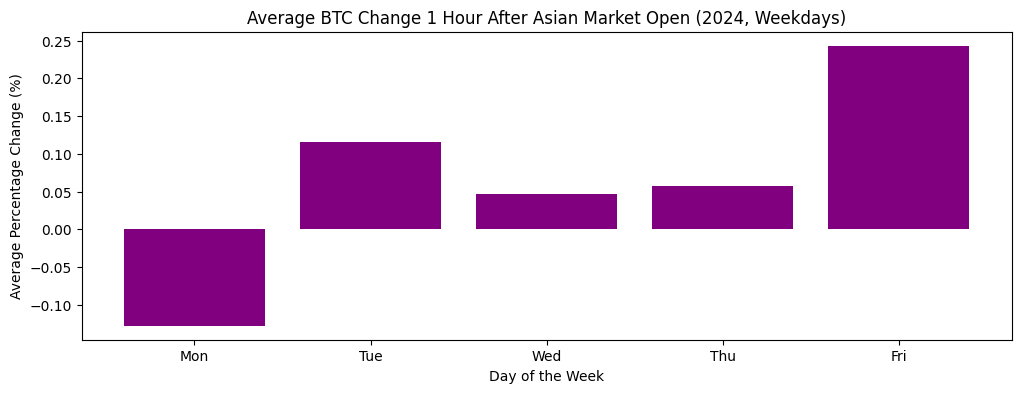

In [ ]:
df = pd.read_csv("btcdata.csv")
df = df.dropna()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.set_index('Timestamp')

df = df.loc['2025']

jst = pytz.timezone('Asia/Tokyo')
asian_market_open_hour_jst = 9


def get_hourly_change_after_asian_open(data):
    data = data.tz_localize('UTC').tz_convert(jst)
    data = data[data.index.dayofweek < 5]

    jp_holidays = holidays.JP(years=data.index.year.unique())
    data = data[~pd.to_datetime(data.index.date).isin(jp_holidays)]

    data_at_open = data[data.index.hour == asian_market_open_hour_jst]
    data_one_hour_later = data[data.index.hour == asian_market_open_hour_jst + 1]

    merged_data = pd.merge(
        data_at_open['Close'].rename('Open').reset_index(),
        data_one_hour_later['Close'].rename('Close_1h_Later').reset_index(),
        left_on=data_at_open.index.date,
        right_on=data_one_hour_later.index.date,
        how='inner'
    )

    merged_data['Timestamp'] = pd.to_datetime(merged_data['Timestamp_x'])
    merged_data = merged_data.set_index('Timestamp')
    merged_data = merged_data.drop(['Timestamp_x', 'Timestamp_y'], axis=1)

    merged_data['Change'] = (merged_data['Close_1h_Later'] - merged_data['Open']) / merged_data['Open'] * 100
    return merged_data

hourly_change_data = get_hourly_change_after_asian_open(df)


def calculate_average_change_per_day(data):
    data_copy = data.copy()
    data_copy['DayOfWeek'] = data_copy.index.dayofweek
    average_change = data_copy.groupby('DayOfWeek')['Change'].mean()

    return average_change

avg_change_by_day = calculate_average_change_per_day(hourly_change_data)

days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
plt.figure(figsize=(12, 4))
plt.bar(days_of_week, [avg_change_by_day.get(i, 0) for i in range(5)], color='purple')

plt.title('Average BTC Change 1 Hour After Asian Market Open (2024, Weekdays)')
plt.xlabel('Day of the Week') ; plt.ylabel('Average Percentage Change (%)')
plt.show()